# 1. Análisis Exploratorio de Datos (EDA)
En este notebook realizaremos un análisis exploratorio inicial de los datos del challenge de clasificación biomédica.

In [1]:
from pathlib import Path
import sys

# Configurar el path del proyecto
notebook_dir = Path().absolute()
project_root = notebook_dir.parent

# Agregar src al path de Python
sys.path.append(str(project_root))

In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Importar módulos personalizados
from src.exploration.eda import ExploratoryAnalysis
from src.exploration.baseline import BaselineModel

# Configuración de visualización
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette('husl')
%matplotlib inline

print("Configuración inicial completada. Project root:", project_root)

Configuración inicial completada. Project root: c:\Users\User\Desktop\Programacion\Python\Classification-App


C:\Users\User\AppData\Local\Temp\ipykernel_14004\692071792.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# Definir la ruta al dataset
DATA_PATH = project_root / "data" / "raw" / "challenge_data-18-ago.csv"

# Cargar el dataset directamente
df = pd.read_csv(DATA_PATH, sep=';')

# Convertir las etiquetas a listas
df['group'] = df['group'].apply(lambda x: x.split('|'))

# Crear instancia de ExploratoryAnalysis con el DataFrame
class ExploratoryAnalysisWithDF(ExploratoryAnalysis):
    def __init__(self, df):
        self.df = df

eda = ExploratoryAnalysisWithDF(df)

# Mostrar información básica del dataset
print("Dimensiones del dataset:", df.shape)
print("\nInformación del dataset:")
print(df.info())

print("\nPrimeras 3 filas del dataset:")
display(df.head(3))

# Mostrar estadísticas de las columnas de texto
print("\nEstadísticas de las columnas:")
text_stats = df.describe(include=[object])
display(text_stats)

Dimensiones del dataset: (3565, 3)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     3565 non-null   object
 1   abstract  3565 non-null   object
 2   group     3565 non-null   object
dtypes: object(3)
memory usage: 83.7+ KB
None

Primeras 3 filas del dataset:


,title,abstract,group
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,"[neurological, hepatorenal]"
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,[neurological]
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,[hepatorenal]



Estadísticas de las columnas:


,title,abstract,group
count,3565,3565,3565
unique,3563,3565,15
top,State-of-the-art thiazide diuretics for prosta...,Adrenoleukodystrophy ( ALD ) is a genetically ...,[neurological]
freq,2,1,1058


In [4]:
# Implementar el modelo baseline directamente en el notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold

class NotebookBaselineModel:
    def __init__(self, max_features: int = 5000):
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, 2),
            stop_words='english'
        )
        self.mlb = MultiLabelBinarizer()
        self.model = OneVsRestClassifier(LogisticRegression(C=1.0, max_iter=1000))
    
    def train_and_evaluate(self, titles, abstracts, labels, n_splits=5):
        # Preparar features
        combined_text = [f"{title}. {abstract}" for title, abstract in zip(titles, abstracts)]
        X = self.vectorizer.fit_transform(combined_text)
        y = self.mlb.fit_transform(labels)
        
        # Inicializar K-Fold
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        # Métricas a calcular
        scores = {
            'accuracy': [],
            'f1_weighted': [],
            'f1_macro': [],
            'f1_micro': []
        }
        
        # Matrices de confusión por clase
        conf_matrices = {label: np.zeros((2, 2)) for label in self.mlb.classes_}
        
        # Para cada fold
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Entrenar y predecir
            self.model.fit(X_train, y_train)
            y_pred = self.model.predict(X_val)
            
            # Calcular métricas
            scores['accuracy'].append(accuracy_score(y_val, y_pred))
            scores['f1_weighted'].append(f1_score(y_val, y_pred, average='weighted'))
            scores['f1_macro'].append(f1_score(y_val, y_pred, average='macro'))
            scores['f1_micro'].append(f1_score(y_val, y_pred, average='micro'))
            
            # Calcular matriz de confusión para cada clase
            for i, label in enumerate(self.mlb.classes_):
                conf_matrices[label] += confusion_matrix(y_val[:, i], y_pred[:, i])
        
        # Normalizar matrices de confusión
        for label in conf_matrices:
            conf_matrices[label] = conf_matrices[label] / n_splits
        
        return scores, conf_matrices, self.mlb.classes_
    
    def plot_results(self, scores, conf_matrices, class_names):
        # Mostrar métricas
        metrics_df = pd.DataFrame({
            'metric': list(scores.keys()),
            'mean': [np.mean(v) for v in scores.values()],
            'std': [np.std(v) for v in scores.values()]
        })
        
        print("Resultados por métrica:")
        for idx, row in metrics_df.iterrows():
            print(f"{row['metric']}: {row['mean']:.3f} ± {row['std']:.3f}")
        
        # Visualizar métricas
        plt.figure(figsize=(10, 6))
        bars = plt.bar(metrics_df['metric'], metrics_df['mean'])
        plt.errorbar(metrics_df['metric'], metrics_df['mean'], 
                    yerr=metrics_df['std'], fmt='none', capsize=5, color='black')
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.title('Métricas del Modelo Baseline')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Visualizar matrices de confusión
        n_classes = len(conf_matrices)
        n_cols = min(3, n_classes)
        n_rows = (n_classes + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_classes > 1:
            axes = axes.ravel()
        else:
            axes = [axes]
        
        for i, (class_name, conf_matrix) in enumerate(conf_matrices.items()):
            conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
            sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i],
                       xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
            axes[i].set_title(f'Matriz de Confusión - {class_name}')
            axes[i].set_xlabel('Predicho')
            axes[i].set_ylabel('Real')
        
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        return metrics_df

print("NotebookBaselineModel definido correctamente.")

NotebookBaselineModel definido correctamente.


Análisis de Distribución de Clases:



Estadísticas por clase:


,Cantidad,Porcentaje
neurological,1785,50.070126
cardiovascular,1268,35.568022
hepatorenal,1091,30.603086
oncological,601,16.858345



Estadísticas de cardinalidad de etiquetas:
count: 3565.00
mean: 1.33
std: 0.52
min: 1.00
25%: 1.00
50%: 1.00
75%: 2.00
max: 4.00


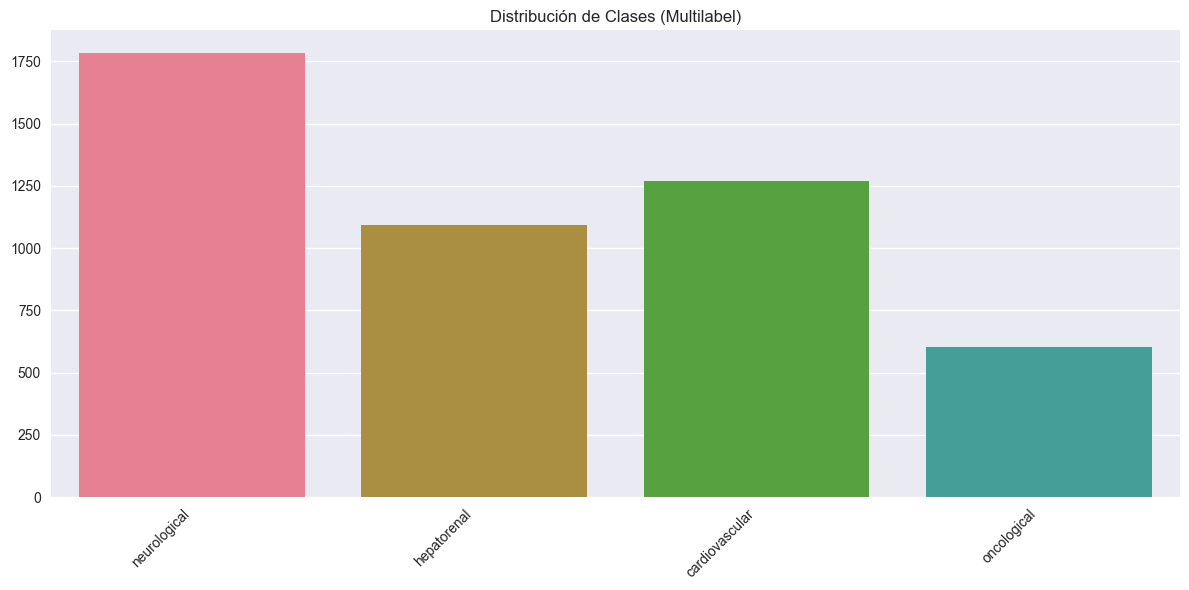

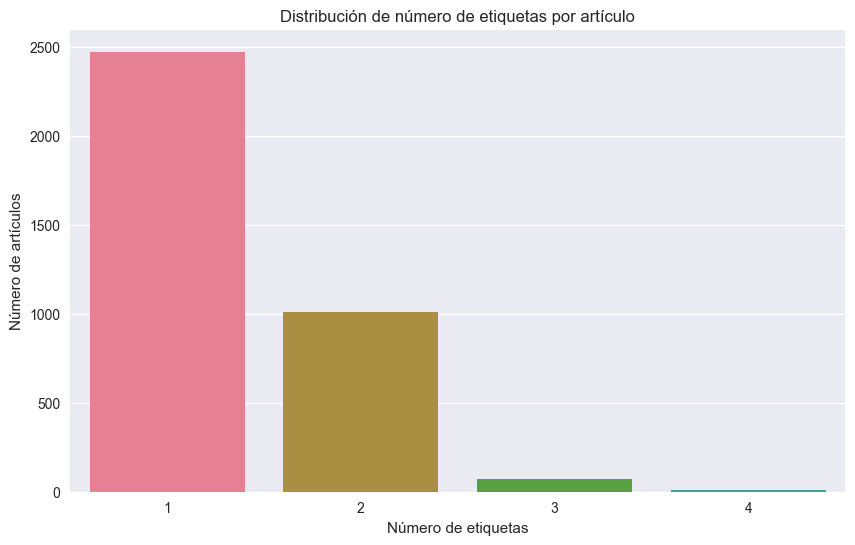

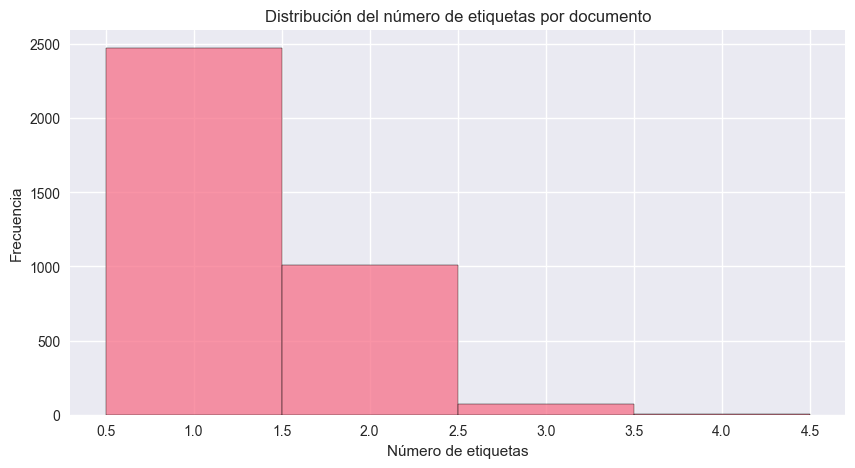

In [5]:
# Analizar distribución de clases
print("Análisis de Distribución de Clases:")
class_dist = eda.analyze_class_distribution()

# Convertir a DataFrame para mejor visualización
class_dist_df = pd.DataFrame({
    'Cantidad': class_dist.values(),
    'Porcentaje': [count/len(df)*100 for count in class_dist.values()]
}, index=class_dist.keys())

print("\nEstadísticas por clase:")
display(class_dist_df.sort_values('Cantidad', ascending=False))

# Analizar cardinalidad de etiquetas
label_card = eda.analyze_label_cardinality()
print("\nEstadísticas de cardinalidad de etiquetas:")
print("\n".join(f"{metric}: {value:.2f}" for metric, value in label_card['stats'].items()))

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x=df['group'].apply(len), discrete=True)
plt.title('Distribución del número de etiquetas por documento')
plt.xlabel('Número de etiquetas')
plt.ylabel('Frecuencia')
plt.show()

Análisis de Longitud de Textos:

Estadísticas de longitud de títulos:


,count,mean,std,min,25%,50%,75%,max
title,3565.0,69.345021,36.671448,20.0,43.0,55.0,88.0,294.0



Estadísticas de longitud de abstracts:


,count,mean,std,min,25%,50%,75%,max
abstract,3565.0,696.545582,579.555153,180.0,271.0,312.0,1138.0,3814.0



Análisis de Duplicados:

Duplicados exactos:
  - Cantidad: 0
  - Porcentaje: 0.00%

Duplicados en títulos:
  - Cantidad: 2
  - Porcentaje: 0.06%

Duplicados en abstracts:
  - Cantidad: 0
  - Porcentaje: 0.00%

Análisis de Co-ocurrencia de Etiquetas:


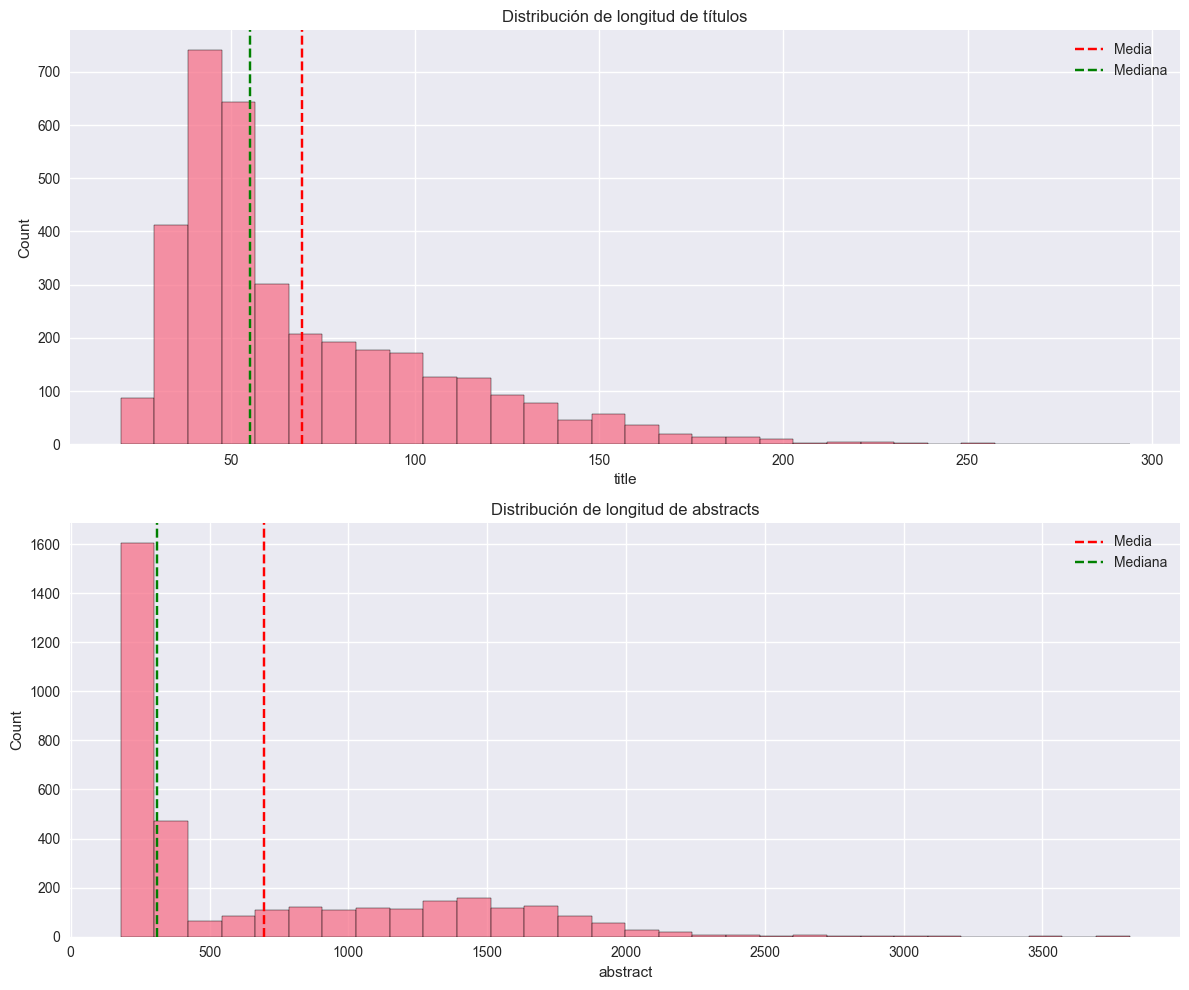

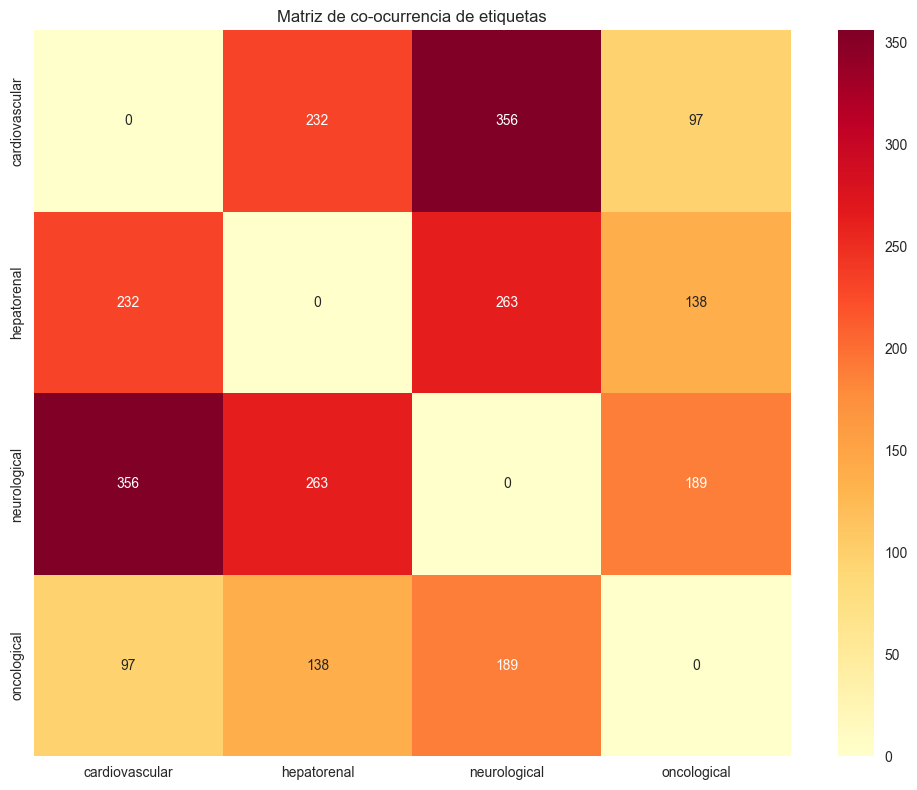


Co-ocurrencias más frecuentes:


,pair,count
1,cardiovascular - neurological,356
3,hepatorenal - neurological,263
0,cardiovascular - hepatorenal,232
5,neurological - oncological,189
4,hepatorenal - oncological,138
2,cardiovascular - oncological,97


In [6]:
# Analizar longitud de textos
print("Análisis de Longitud de Textos:")
text_stats = eda.analyze_text_length()

# Mostrar estadísticas de títulos
print("\nEstadísticas de longitud de títulos:")
display(pd.DataFrame(text_stats['title_stats']).transpose())

# Mostrar estadísticas de abstracts
print("\nEstadísticas de longitud de abstracts:")
display(pd.DataFrame(text_stats['abstract_stats']).transpose())

# Análisis de duplicados manual
print("\nAnálisis de Duplicados:")

# Convertir las etiquetas a strings para la comparación
df_temp = df.copy()
df_temp['group_str'] = df_temp['group'].apply('|'.join)

# Verificar duplicados exactos
exact_duplicates = df_temp[['title', 'abstract', 'group_str']].duplicated().sum()
title_duplicates = df_temp['title'].duplicated().sum()
abstract_duplicates = df_temp['abstract'].duplicated().sum()

print("\nDuplicados exactos:")
print(f"  - Cantidad: {exact_duplicates}")
print(f"  - Porcentaje: {(exact_duplicates / len(df)) * 100:.2f}%")

print("\nDuplicados en títulos:")
print(f"  - Cantidad: {title_duplicates}")
print(f"  - Porcentaje: {(title_duplicates / len(df)) * 100:.2f}%")

print("\nDuplicados en abstracts:")
print(f"  - Cantidad: {abstract_duplicates}")
print(f"  - Porcentaje: {(abstract_duplicates / len(df)) * 100:.2f}%")

# Análisis de co-ocurrencia de etiquetas manual
print("\nAnálisis de Co-ocurrencia de Etiquetas:")

# Obtener todas las etiquetas únicas como lista ordenada
all_labels = sorted(list(set([label for labels in df['group'] for label in labels])))

# Crear matriz de co-ocurrencia
co_matrix = pd.DataFrame(0, index=all_labels, columns=all_labels)

# Llenar matriz
for labels in df['group']:
    for l1 in labels:
        for l2 in labels:
            if l1 != l2:
                co_matrix.loc[l1, l2] += 1

# Mostrar la matriz
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, cmap='YlOrRd', fmt='g')
plt.title('Matriz de co-ocurrencia de etiquetas')
plt.tight_layout()
plt.show()

print("\nCo-ocurrencias más frecuentes:")
# Obtener las co-ocurrencias más frecuentes
co_pairs = []
for i in range(len(all_labels)):
    for j in range(i+1, len(all_labels)):
        l1, l2 = all_labels[i], all_labels[j]
        co_pairs.append({
            'pair': f"{l1} - {l2}",
            'count': co_matrix.loc[l1, l2]
        })

co_pairs_df = pd.DataFrame(co_pairs)
display(co_pairs_df.sort_values('count', ascending=False))

Entrenando Modelo Baseline...

Realizando validación cruzada...

Visualizando resultados...
Resultados por métrica:
accuracy: 0.667 ± 0.016
f1_weighted: 0.813 ± 0.009
f1_macro: 0.778 ± 0.006
f1_micro: 0.822 ± 0.009


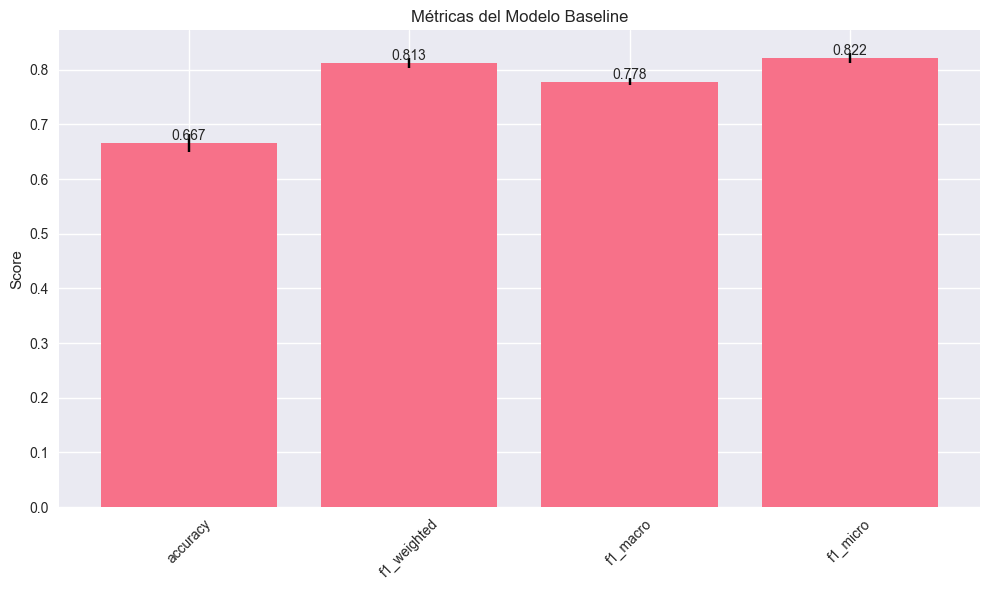

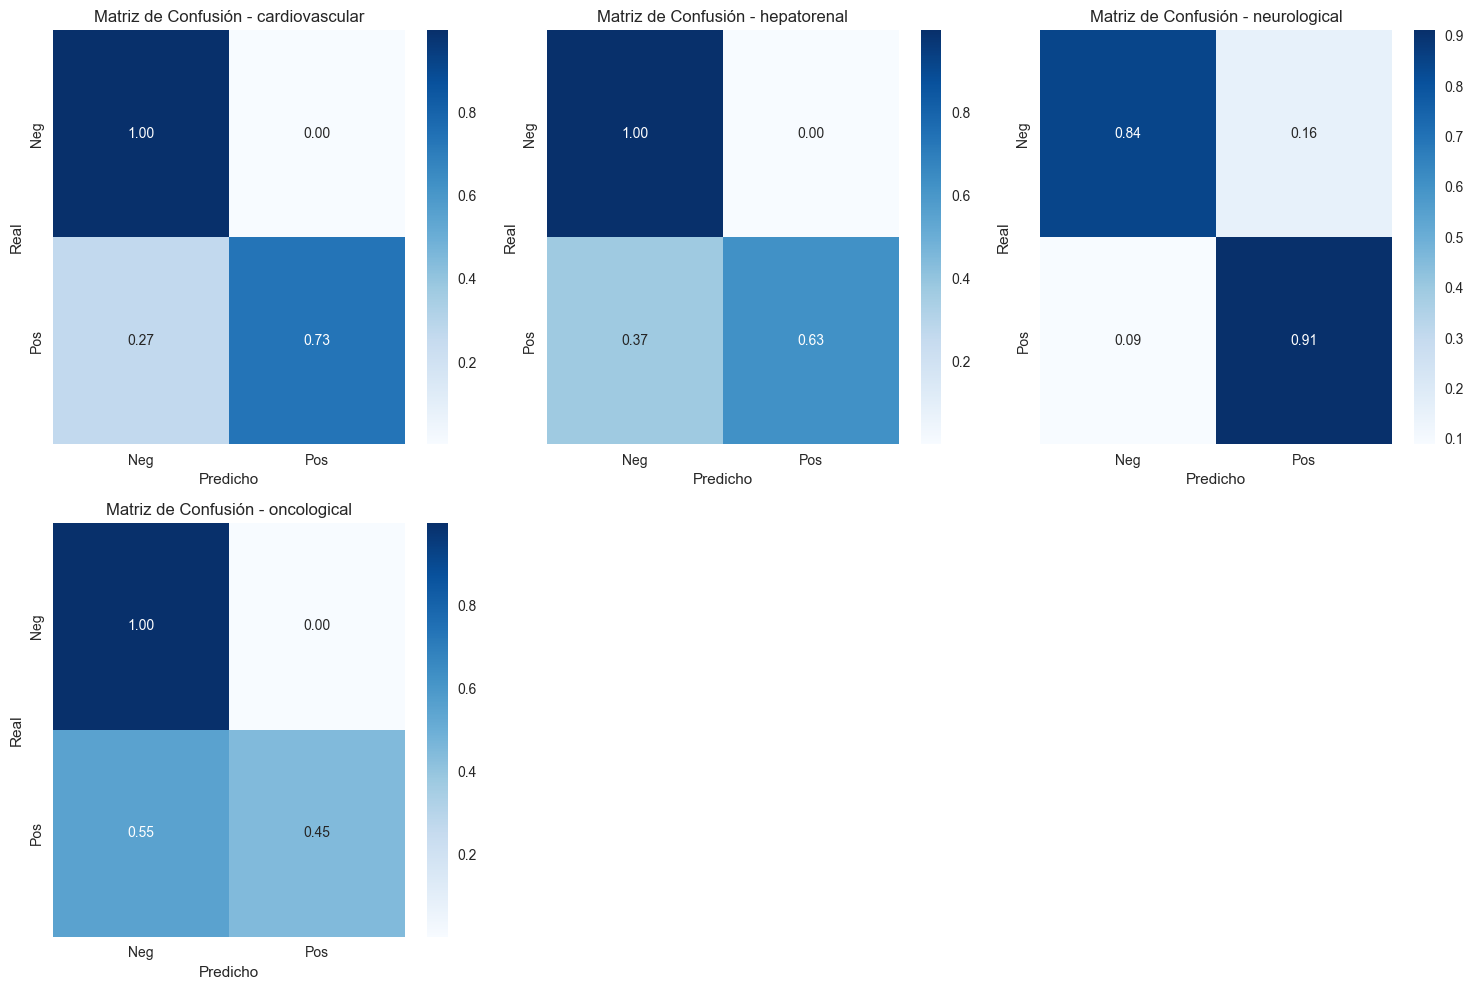


Resumen del modelo baseline:
-------------------------
Total de muestras: 3565
Número de clases: 4
Cardinalidad promedio de etiquetas: 1.33
Mejores métricas:
- accuracy: 0.667 ± 0.016
- f1_weighted: 0.813 ± 0.009
- f1_macro: 0.778 ± 0.006
- f1_micro: 0.822 ± 0.009


In [7]:
# Entrenar y evaluar el modelo baseline
print("Entrenando Modelo Baseline...")

# Inicializar el modelo
baseline = NotebookBaselineModel(max_features=5000)

# Preparar los datos
titles = df['title'].tolist()
abstracts = df['abstract'].tolist()
labels = df['group'].tolist()

# Entrenar y evaluar
print("\nRealizando validación cruzada...")
scores, conf_matrices, class_names = baseline.train_and_evaluate(
    titles=titles,
    abstracts=abstracts,
    labels=labels,
    n_splits=5
)

# Visualizar resultados
print("\nVisualizando resultados...")
metrics_df = baseline.plot_results(scores, conf_matrices, class_names)

# Resumen final
print("\nResumen del modelo baseline:")
print("-------------------------")
print(f"Total de muestras: {len(df)}")
print(f"Número de clases: {len(class_names)}")
print(f"Cardinalidad promedio de etiquetas: {np.mean([len(labs) for labs in labels]):.2f}")
print("Mejores métricas:")
for metric, values in scores.items():
    mean_score = np.mean(values)
    std_score = np.std(values)
    print(f"- {metric}: {mean_score:.3f} ± {std_score:.3f}")